# Initial load of program

### Imports

In [2]:
import numpy as np
import pandas as pd
import regex as re
import networkx as nx
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper
import warnings

warnings.filterwarnings('ignore')

### Build graph of item

In [6]:
def build_graph(node: str):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(f"""
        CONSTRUCT {{ {node} ?p ?object .
                    ?object ?p1 ?subject1 .
                    ?subject ?p2 {node} .
                    ?subject2 ?p3 ?subject .
                    ?subject3 ?p4 ?object . 
                    ?subject ?p5 ?subject4 }} 
        WHERE       {{
                    {{ {node} ?p ?object .
                    ?object ?p1 ?subject1 .
                    ?subject3 ?p4 ?object .
                    FILTER isURI(?object)
                    FILTER isURI(?subject1)
                    FILTER isURI(?subject3) }}
                    UNION
                    {{ ?subject ?p2 {node} .
                    ?subject2 ?p3 ?subject .
                    ?subject ?p5 ?subject4 . 
                    FILTER isURI(?subject)
                    FILTER isURI(?subject2)
                    FILTER isURI(?subject4) }}
                    }}
                """)
    query_result = sparql.queryAndConvert()  # Produces an RDFlib Graph object 
    query_df = pd.DataFrame(query_result, columns=["Subject", "Property", "Value"])
    query_df["Subject"] = query_df["Subject"].str.replace("rdflib.term.URIRef", "")
    query_df["Value"] = query_df["Value"].str.replace("rdflib.term.URIRef", "")
    discard_properties = ["P921", "P2860"]
    query_df = query_df[~query_df.Property.str.contains('|'.join(discard_properties))]

    G = nx.Graph()
    G = nx.from_pandas_edgelist(query_df, "Subject", "Value")
    return G
    
test = build_graph("wd:Q171076")

### Determining merge candidates

In [11]:
def alt_merge_candidates(graph: object, source_node: str):
    neighbor_dict = {}  # Dict to store nodes and the number of common neighbors with the source-node
    source_node_neighbors = [n for n in graph.neighbors(source_node)]  # List containing the source-node's neighbors 
    
    for item in source_node_neighbors:
        item_neighbors = [n for n in graph.neighbors(item)]
        common_neighbors = sum(n in source_node_neighbors for n in item_neighbors)
        neighbor_dict[item] = common_neighbors
    return sorted(neighbor_dict.items(), key=lambda item: item[1], reverse=True)

In [12]:
alt_merge_candidates(test, "http://www.wikidata.org/entity/Q171076")

[('http://www.wikidata.org/entity/Q65464996', 3),
 ('http://www.wikidata.org/entity/Q555853', 3),
 ('http://www.wikidata.org/entity/Q9177986', 2),
 ('http://www.wikidata.org/entity/Q65464991', 2),
 ('http://www.wikidata.org/entity/Q1191614', 2),
 ('http://www.wikidata.org/entity/Q106595715', 2),
 ('http://www.wikidata.org/entity/Q12705', 2),
 ('http://www.wikidata.org/entity/Q14515877', 2),
 ('http://www.wikidata.org/entity/Q289633', 1),
 ('http://www.wikidata.org/entity/Q1786184', 1),
 ('http://www.wikidata.org/entity/Q328249', 1),
 ('http://www.wikidata.org/entity/statement/Q171076-9249c868-4506-8700-0a7e-21f71660b4dc',
  1),
 ('http://www.wikidata.org/entity/L30165-S1', 1),
 ('http://www.wikidata.org/entity/statement/Q171076-b0c44c29-4f31-4df0-3009-582278b2529d',
  1),
 ('http://www.wikidata.org/entity/statement/Q171076-4e8e3f49-43cd-d67c-0a00-277696737ea9',
  1),
 ('http://www.wikidata.org/entity/Q2488244', 1),
 ('http://www.wikidata.org/entity/statement/Q9177986-9A28ED15-0E69-46FD

In [14]:
def build_graph(node: str):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery("""
        CONSTRUCT { wd:Q171076 wdtn:P227 ?val .
                    wd:Q338712 wdtn:P227 ?val1}
        WHERE     { wd:Q171076 wdtn:P227 ?val .
                    wd:Q338712 wdtn:P227 ?val1}
                """)
    query_result = sparql.queryAndConvert()  # Produces an RDFlib Graph object 
    query_df = pd.DataFrame(query_result, columns=["Subject", "Property", "Value"])
    query_df["Subject"] = query_df["Subject"].str.replace("rdflib.term.URIRef", "")
    query_df["Value"] = query_df["Value"].str.replace("rdflib.term.URIRef", "")
    discard_properties = ["P921", "P2860"]
    query_df = query_df[~query_df.Property.str.contains('|'.join(discard_properties))]

    G = nx.Graph()
    G = nx.from_pandas_edgelist(query_df, "Subject", "Value")
    return G

test2 = build_graph('ewr')

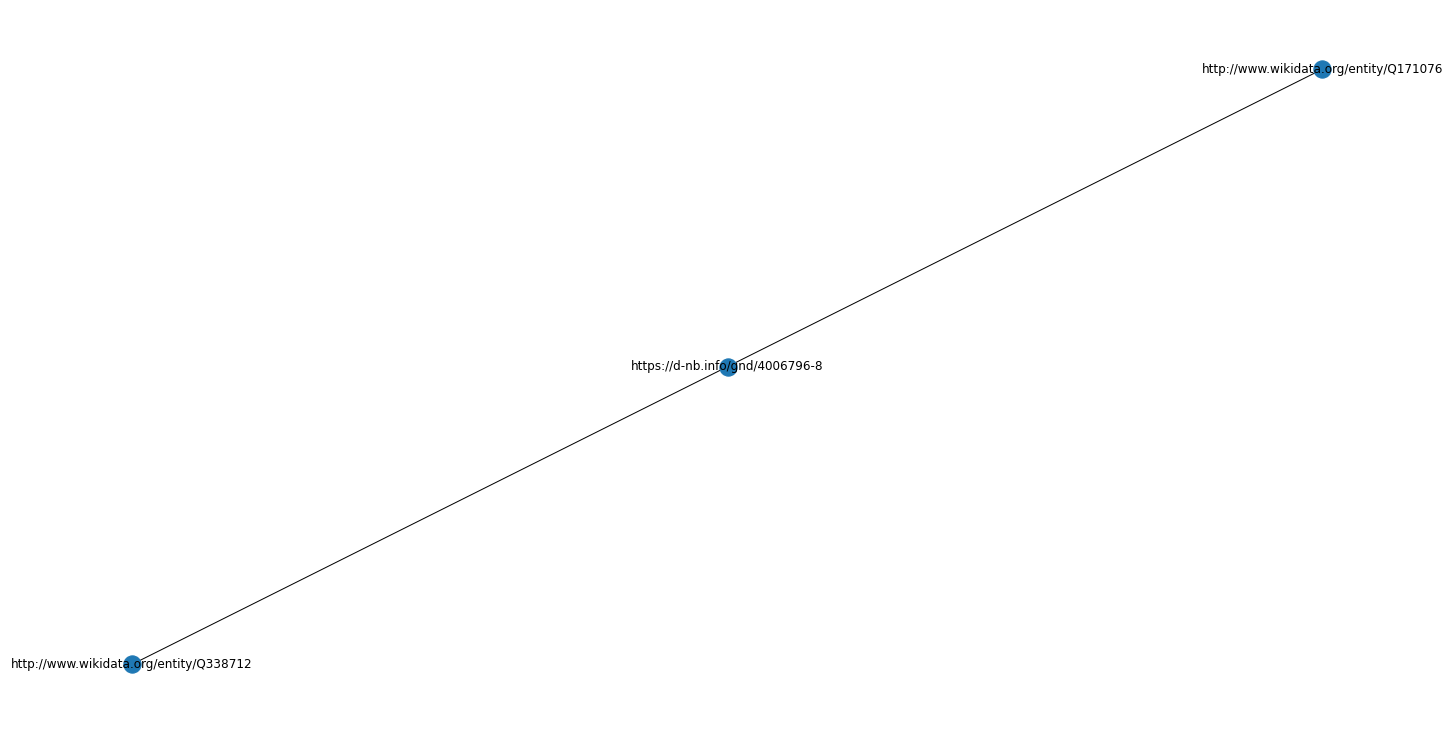

In [16]:
plt.figure(figsize=(20,10))
nx.draw(test2, with_labels=True)